In [4]:
import os
import cv2
import requests
import numpy as np
import seaborn as sns
import matplotlib as plt
import sklearn

import tensorflow as tf
import tensorflow_hub as hub

from tf_keras import layers 

# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

In [7]:
# Define the GitHub repository URL
github_model_url = "https://github.com/RKPen/Project/raw/main/Trained_Model"

# Define the directory where you want to save the model files
destination_dir = "destination_directory"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Create a variables directory within the destination directory
variables_dir = os.path.join(destination_dir, "variables")
if not os.path.exists(variables_dir):
    os.makedirs(variables_dir)

# List of model files
model_files = [
    "asset/*",
    "variables/variables.data-00000-of-00001",
    "variables/variables.index",
    "fingerprint.pb",
    "keras_metadata.pb",
    "saved_model.pb"
]

# Download each file in the list
for file in model_files:
    file_url = f"{github_model_url}/{file}"
    file_name = file.split("/")[-1]  # Extract file name from the URL
    
    # Adjust file path for variables files
    if "variables" in file:
        file_path = os.path.join(variables_dir, file.split("/")[-1])
    else:
        file_path = os.path.join(destination_dir, file_name)

    # Download the file
    response = requests.get(file_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the file
        with open(file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {file_name}")
        
        # If it's a variables file, remove it from the root directory
        if "variables" in file:
            root_file_path = os.path.join(destination_dir, file.split("/")[-1])
            if os.path.exists(root_file_path):
                os.remove(root_file_path)
                print(f"Removed from root directory: {file.split('/')[-1]}")
    else:
        print(f"Failed to download: {file_name}")


Failed to download: *
Downloaded: variables.data-00000-of-00001
Downloaded: variables.index
Downloaded: fingerprint.pb
Downloaded: keras_metadata.pb
Downloaded: saved_model.pb


In [8]:
dataset_path = 'ENTER URL OF DATA TO BE TESTED'

# Define preprocessing function
def preprocess_image(image):
    # Preprocess input image using ResNet V2 preprocessing function
    return keras.applications.resnet_v2.preprocess_input(image)

# Create an ImageDataGenerator for preprocessing images
data_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_image
)

# Load and preprocess training data
data_flow = data_generator.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Resize images to 128 X 128
    batch_size=32,
    class_mode='categorical',
)



Found 5131 images belonging to 9 classes.


In [9]:
from sklearn.metrics import classification_report


# Initialize empty lists to store predictions and true labels
all_predicted_labels = []
all_true_labels = []


# Load the saved model
saved_model_path = "destination_directory"
saved_model = keras.models.load_model(saved_model_path)

# Iterate over the generator to get predictions batch by batch
for i in range(len(data_flow)):
    x_batch, y_batch = data_flow[i]
    
    # Generate predictions for the current batch
    batch_predictions = saved_model.predict(x_batch)
    
    # Convert predictions to class labels
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    # Convert true labels to class indices if they are one-hot encoded
    if y_batch.shape[1] > 1:
        batch_true_labels = np.argmax(y_batch, axis=1)
    else:
        batch_true_labels = y_batch
    
    # Accumulate batch predictions and true labels
    all_predicted_labels.extend(batch_predicted_labels)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Generate classification report
class_names = list(data_flow.class_indices.keys())
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))


1/1 [==============================] - 1s 845ms/step
              precision    recall  f1-score   support

           1       1.00      0.93      0.96      1650
           2       0.99      0.99      0.99        71
           3       0.85      0.98      0.91       665
           4       0.92      0.95      0.93       514
           5       0.96      0.96      0.96        27
           6       0.93      0.94      0.94       107
           7       0.95      0.98      0.96       665
           8       0.97      0.93      0.95       772
           9       0.90      0.90      0.90       660

    accuracy                           0.94      5131
   macro avg       0.94      0.95      0.94      5131
weighted avg       0.94      0.94      0.94      5131



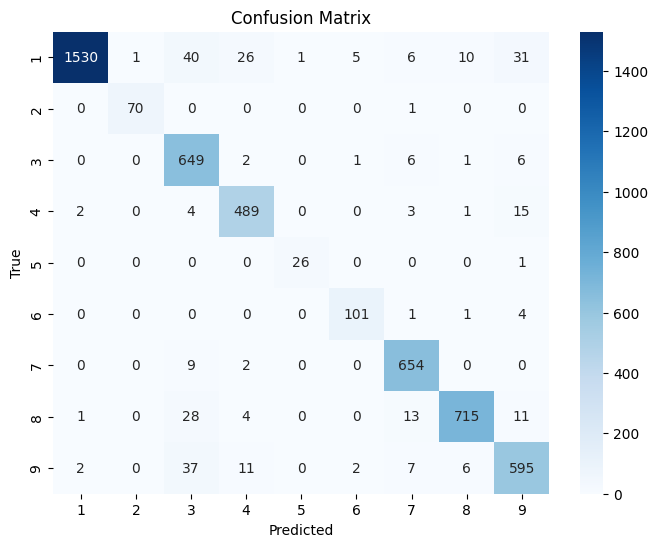

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()